### Convert images to TFRecords file. 
Refer to https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/how_tos/reading_data/convert_to_records.py

In [ ]:
from PIL import Image
import numpy as np
import tensorflow as tf
import os

def _int64_feature(value):
  """Wrapper for inserting int64 features into Example proto."""
  if not isinstance(value, list):
    value = [value]
  return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def _bytes_feature(value):
  """Wrapper for inserting bytes features into Example proto."""
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def main(data_dir, tfrecords_filename):
    labels = os.listdir(data_dir)
    writer = tf.python_io.TFRecordWriter(tfrecords_filename)
    for label in labels:
        path = os.path.join(data_dir, label)
        img_files = os.listdir(path)
        for file in img_files:
            # The reason to store image sizes was demonstrated
            # in the previous example -- we have to know sizes
            # of images to later read raw serialized string,
            # convert to 1d array and convert to respective
            # shape that image used to have.
            img_path = os.path.join(path, file)
            img = np.array(Image.open(img_path))
            height = img.shape[0]
            width = img.shape[1]
            img_raw = img.tostring()

            example = tf.train.Example(features=tf.train.Features(feature={
            'height': _int64_feature(height),
            'width': _int64_feature(width),
            'image_raw': _bytes_feature(img_raw),
            'label': _int64_feature(int(label))}))
            writer.write(example.SerializeToString())
    writer.close()

if __name__ == '__main__':
    data_dir = './tempimg'
    tfrecords_filename = 'validation.tfrecords'
    main(data_dir = data_dir, tfrecords_filename = tfrecords_filename)

### Feed images from TFRecords file randomly
Refer to: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/how_tos/reading_data/fully_connected_reader.py

2 (2, 299, 299, 3) (2,)
current batch


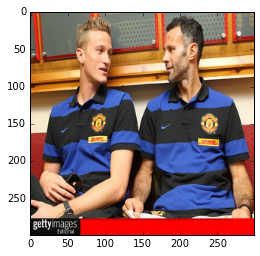

1


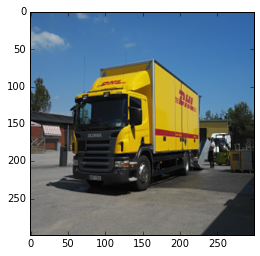

1
current batch


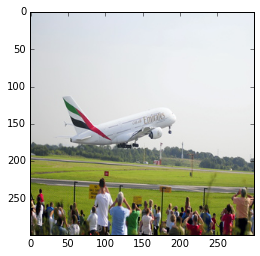

0


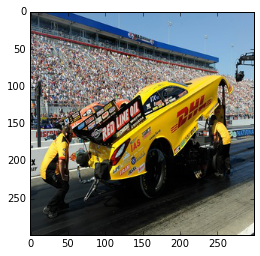

1


In [2]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
filename = 'validation.tfrecords'

def read_and_decode(filename):
	reader = tf.TFRecordReader()
	_,serialized_example = reader.read(filename)
	features = tf.parse_single_example(serialized_example, 
		features = {
		'height': tf.FixedLenFeature([],tf.int64), 
		'width': tf.FixedLenFeature([], tf.int64),
		'image_raw': tf.FixedLenFeature([], tf.string),
		'label': tf.FixedLenFeature([], tf.int64)})
	image = tf.decode_raw(features['image_raw'], tf.uint8)
	label = tf.cast(features['label'], tf.int32)
	height = tf.cast(features['height'], tf.int32)
	width = tf.cast(features['width'], tf.int32)
    
	image_shape = tf.pack([height, width, 3])
	image = tf.reshape(image, image_shape)
	images, labels = tf.train.shuffle_batch([image, label], shapes = [(299,299,3),()],
                                            batch_size = 2, capacity = 300, 
                                            num_threads=2, 
                                            min_after_dequeue = 10)
	print 2, images.get_shape(), labels.get_shape()
	return images, labels

filename_queue = tf.train.string_input_producer([filename], num_epochs=100)
image, label = read_and_decode(filename_queue)
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

with tf.Session() as sess:
    sess.run(init_op)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    for i in xrange(2):
        img, lab = sess.run([image, label])
        #print img[0,:,:,:].get_shape()
        print 'current batch'

        plt.imshow(img[0, :, :, :])
        plt.show()
        print lab[0]
        plt.imshow(img[1, :, :, :])
        plt.show()
        print lab[1]
    coord.request_stop()
    coord.join(threads)

In [1]:
import tensorflow as tf
print tf.__version__

0.12.1
